## Introduction

The goal of the **fastbookRAG** project is to answer questions from the [fastbook](https://github.com/fastai/fastbook/tree/master) end-of-chapter Questionnaires using the following pipeline:



![fastbookRAG diagram](1.png)

This notebook establishes a baseline using BM25 for keyword-based retrieval on chunks of the fastbook chapters covered in [Part 1 of the fastai course](https://course.fast.ai/) (1, 2, 4, 8, 9, 10, and 13). I generate keywords (for full text search) for each question [using the Claude-3.5-Sonnet API (using the Answer.AI library `claudette`)](https://vishalbakshi.github.io/blog/posts/2024-08-27-fastbookRAG-claude-keywords/).

The evaluation metric for each question, that I'm simply calling **score**, is binary: can the retrieved context answer the question (`1`) or not (`0`)? The evaluation metric across a set of questions, which I'm calling the **Answer Rate**, is the mean score for those questions.

The goal is to retrieve the context necessary to answer all questions. Currently, I manually assess answers. Eventually I'll integrate an LLM into this pipeline to generate (and evaluate) answers based on the retrieved context.

## Summary of Results

Here are the results from my experiments in this notebook---in general, the best performing full text search method (76.7% Answer Rate overall) was retrieving the top-5 (BM25 score) 3-paragraph chunks based on the given set of keywords using FTS5 in sqlite:

|Chapter|BM25_A (Top-1 1p)|BM25_B (Top-3 1p)|BM25_C (Top-5 1p)|BM25_D (Top-1 3p)|BM25_E (Top-3 3p)|BM25_F (Top-5 3p)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
1|40% (12/30)|56.7% (17/30)|60% (18/30)|63.3% (19/30)|83.3% (25/30)|90% (27/30)|
2|38.5% (10/26)|65.4% (17/26)|69.2% (18/26)|46.2% (12.26)|80.8% (21/26)|80.8% (21/26)|
4|25% (8/32)|68.8% (22/32)|71.9% (23/32)|31.3% (10/32)|71.9% (23/32)|75% (24/32)|
8|13.8% (4/29)|34.5% (10/29)|44.8% (13/29)|31% (9/29)|55.2% (16/29)|65.5% (19/29)|
9|13.8% (4/29)|48.3% (14/29)|58.6% (17/29)|34.5% (10/29)|72.4% (21/29)|79.3% (23/29)|
10|47.6% (12/21)|42.9% (9/21)|61.9% (13/21)|38% (8/21)|57.1% (12/21)|61.9% (13/21)|
13|37.1% (13/35)|54.3% (19/35)|60% (21/35)|42.9% (15/35)|68.6% (24/35)|80% (28/35)|
**All**|**30.2% (61/202)**|**53.5% (108/202)**|**60.9% (123/202)**|**41.1% (83/202)**|**70.3% (142/202)**|**76.7% (155/202)**|

## Experimental Setup

### Data Sources

- The freely available Jupyter Notebook-written [fastbook](https://github.com/fastai/fastbook/).

### Data Preprocessing

- Chunking strategy: Single or multiple paragraphs with corresponding headers.
- Rationale: Balances granular content with high-level context.
- Goal: Maintain lean, informative chunks for efficient retrieval.

### Database

I am using sqlite for chunk storage as it's built-in to the python standard library and contains a built-in full text search (FTS5). My database has a single table `fastbook` with a column `text` that has FTS5 enabled.

A typical query looks like:

```sql
SELECT * FROM fastbook
WHERE fastbook MATCH 'keyword1 OR keyword2'
ORDER BY rank
LIMIT 3;
```

## Methodology

### Why BM25?

Key inspirations for why I chose to establish a BM25 baseline:



![Eugene Yan Tweet](eugeneyan_bm25.png)

![Simon Willison Tweet](simonw_bm25.png)

![Shreya Shankar Tweet](sh_reya_bm25.png)

<br>

> Humans love to use keywords. We have very strong tendencies to notice and use certain acronyms, domain-specific words, etc. To capture all this signal, you should ensure your pipeline uses Keyword search. An ongoing joke is that information retrieval has progressed slowly because BM25 is too strong a baseline. _([Beyond the Basics of RAG by Benjamin Clavié](https://parlance-labs.com/education/rag/ben.html))_.

### Evaluation Set


My evaluation set consists of:

- 202 Questionnaire questions.
- "Gold standard" solutions to the Questionnaire [published by fast.ai Leader Tanishq Abraham](https://forums.fast.ai/t/fastbook-chapter-1-questionnaire-solutions-wiki/65647) who says:

> my responses are based on what is supported by the chapter text

(Which is perfect for my retrieval task.)

### Evaluation Metrics

Metrics: **Score** and **Answer Rate**

The evaluation metric for each question, that I'm simply calling **score**, is binary: can the retrieved context answer the question (`1`) or not (`0`)? The evaluation metric across a set of questions, which I'm calling the **Answer Rate**, is the mean score for those questions.

While this is a straightforward pair of metrics, they do involve some judgment. After reading the retrieved context, I decide if it's enough to answer the question. A capable LLM should be able to make the same kind of judgment about whether the context is helpful or not.

## Results

Here are the names and descriptions of each full text search approach explored in this notebook. Top-n means the chunk(s) with the n-highest BM25 score(s).

|Name|Description|
|:-:|:-:|
|BM25_A|Top-1 1-Paragraph Chunks
|BM25_B|Top-3 1-Paragraph Chunks
|BM25_C|Top-5 1-Paragraph Chunks
|BM25_D|Top-1 3-Paragraph Chunks
|BM25_E|Top-3 3-Paragraph Chunks
|BM25_F|Top-5 3-Paragraph Chunks


### Best Approach per Chapter

The following table shows name, description and **Answer Rate** for the best BM25 approach for each Chapter. BM25_F (Top-5 3-paragraph Chunks) was the best performing approach for each chapter and overall. For Chapter 2, BM25_E (Top-3 3-paragraph Chunks) had the same Answer Rate as BM25_F. For Chapter 10, BM25_C (Top-5 1-paragraph Chunks) had the same Answer Rate as BM25_F.

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
|1|BM25_F|Top-5 3-paragraph Chunks|90%|
|2|BM25_E/BM25_F|Top-3/Top-5 3-paragraph Chunks|80.8%|
|4|BM25_F|Top-5 3-paragraph Chunks|75%|
|8|BM25_F|Top-5 3-paragraph Chunks|65.5%|
|9|BM25_F|Top-5 3-paragraph Chunks|79.3%|
|10|BM25_C/BM25_F|Top-5 1-paragraph/3-paragraph Chunks|61.9%|
|13|BM25_F|Top-5 3-paragraph Chunks|80%|
|**All**|**BM25_F**|**Top-5 3-paragraph Chunks**|**76.7%**|

### All Approaches for All Chapters

The following table shows the **Answer Rate** for all BM25 approaches for each chapter (where in the header, 1p = 1-paragraph chunks and 3p = 3-paragraph chunks).

|Chapter|BM25_A (Top-1 1p)|BM25_B (Top-3 1p)|BM25_C (Top-5 1p)|BM25_D (Top-1 3p)|BM25_E (Top-3 3p)|BM25_F (Top-5 3p)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
1|40% (12/30)|56.7% (17/30)|60% (18/30)|63.3% (19/30)|83.3% (25/30)|90% (27/30)|
2|38.5% (10/26)|65.4% (17/26)|69.2% (18/26)|46.2% (12.26)|80.8% (21/26)|80.8% (21/26)|
4|25% (8/32)|68.8% (22/32)|71.9% (23/32)|31.3% (10/32)|71.9% (23/32)|75% (24/32)|
8|13.8% (4/29)|34.5% (10/29)|44.8% (13/29)|31% (9/29)|55.2% (16/29)|65.5% (19/29)|
9|13.8% (4/29)|48.3% (14/29)|58.6% (17/29)|34.5% (10/29)|72.4% (21/29)|79.3% (23/29)|
10|47.6% (12/21)|42.9% (9/21)|61.9% (13/21)|38% (8/21)|57.1% (12/21)|61.9% (13/21)|
13|37.1% (13/35)|54.3% (19/35)|60% (21/35)|42.9% (15/35)|68.6% (24/35)|80% (28/35)|
**All**|**30.2% (61/202)**|**53.5% (108/202)**|**60.9% (123/202)**|**41.1% (83/202)**|**70.3% (142/202)**|**76.7% (155/202)**|


A few observations when looking at the **Answer Rate** for each approach for each chapter:

- **Increasing the number of chunks retrieved generally improves the quality of information retrieved**:
  - 1-paragraph chunks
      - For all but Chapter 10, the Answer Rate improves: BM25_C > BM25_B > BM25_A.
  - 3-paragraph chunks
    - For all chapters the Answer Rate improves or stays the same (Chapter 2): BM25_F >= BM25_E > BM25_D

- **Increasing the chunk size generally improves the quality of information retrieved**: For 6 out of 7 chapters (all but Chapter 10), the 3-paragraph chunk Answer Rate (BM25_D, BM25_E, BM25_F) is greater than the corresponding 1-paragraph chunk Answer Rate (BM25A, BM25_B, BM25_C).

- **Not all chapters behave the same**: The Chapter 1 Questionnaire has a higher Answer Rate after increasing chunk size to 3-paragraphs (BM25_C: 60%, BM25_D: 63.3%). On the other extreme, for Chapter 10, increasing the chunk size to 3-paragraphs (BM25_D, 38%) performs worse than the worst-performing 1-paragraph approach (BM25_B, 42.9%). Chapter 10 is also an anomaly within 1-paragraph results: the Answer Rate for Top-3 (BM25_B, 42.9%) is less than Top-1 (BM25_A, 47.6%) while for every other chapter, BM25_A > BM25_B. For 3-paragraph chunks, Chapter 2's Answer Rate doesn't improve like the other chapters from Top-3 (BM25_E: 80.8%) to Top-5 (BM25_F: 80.8%).

- **Changing the data in the database changes the corpus-wide statistics**: In sqlite, BM25 is calculated using corpus-wide statistics. If the data changes, the calculation changes. I noticed a significant improvement in the quality of context retrieved for 3-paragraph chunks when compared to 1-paragraph chunks (sometimes even the first chunk was different for the same question).

Performance varied across chapters due to differences in content and question types:

- Chapter 1 (best performer, 90% with BM25_F) is introductory, defining many terms well-suited for keyword search.
- Chapter 10 (worst performer, 61.9% with BM25_F)
  - Had the fewest questions (21), which are less granular than other chapters. Each missed question was a ~5% Answer Rate hit.
  - Retrieved contexts often contained relevant keywords but lacked direct answers.
- Chapter 8 (second-worst) faced challenges with:
  - Ambiguous questions (e.g., "How does it solve it?").
  - Technical terms (e.g., function names) rare in explanatory text but common in code chunks.
  - Overuse of certain terms (e.g., "latent factor") diluting relevance.

### Question-Level Analysis

Looking at the question-level data offers some additional insights.

In [75]:
import pandas as pd
url = 'https://gist.githubusercontent.com/vishalbakshi/4379c92665695b8bd9ab83a1f3ab6b55/raw/97a22f0736b5e179efb8c9d70e5ec80a5b8f4817/fastbookRAG_bm25_all.csv'
df = pd.read_csv(url)
score_columns = df.filter(regex='_score$').columns
df['total_score'] = df[score_columns].sum(axis=1)

#### Distribution of Scores

Here are my takeaways from the distribution of scores:

- Bimodal Distribution
  - Approximately 50 questions (about 25% of the total) were successfully answered by all six full text search methods (a total score of `6`).
  - On the other hand, around 40 questions (about 20%) couldn't be answered by any method, resulting in a total score of `0`.
- Uniform Mid-Range Performance
  - Questions answered by 2, 3, 4, or 5 methods each accounted for 20-30 instances, showing a relatively even distribution in this middle range.
- Least Common Outcome
  - Only 10 questions were answered by just one method, making this the least frequent result.

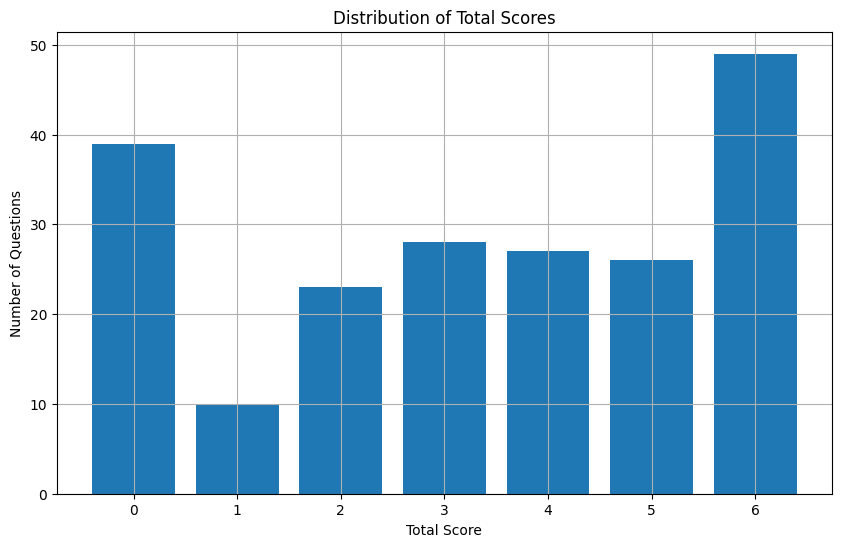

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

df['total_score'].hist(bins=range(0, 8), align='left', rwidth=0.8);

plt.title('Distribution of Total Scores')
plt.xlabel('Total Score')
plt.ylabel('Number of Questions');

#### Average Score Per Question

On average, each question was answered by 3 to 4 full text search methods.

In [9]:
df['total_score'].describe()

,total_score
count,202.000000
mean,3.326733
std,2.190476
min,0.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,6.000000


#### Unanswered Questions

There were 39 questions for which none of the full text search approaches retrieved the context needed to answer them:

In [83]:
no_answer = df.query("total_score == 0")[['chapter', 'question_number', 'question_text', 'answer', 'keywords']].drop_duplicates()
no_answer.shape

(39, 5)

For example, the following question never was fully answered by any of the contexts retrieved by the full text search methods.

In [84]:
print(no_answer.iloc[0]['question_text'])
print(no_answer.iloc[0]['answer'])

""What were the two theoretical misunderstandings that held back the field of neural networks?""
""In 1969, Marvin Minsky and Seymour Papert demonstrated in their book, "Perceptrons", that a single layer of artificial neurons cannot learn simple, critical mathematical functions like XOR logic gate. While they subsequently demonstrated in the same book that additional layers can solve this problem, only the first insight was recognized, leading to the start of the first AI winter.
In the 1980's, models with two layers were being explored. Theoretically, it is possible to approximate any mathematical function using two layers of artificial neurons. However, in practices, these networks were too big and too slow. While it was demonstrated that adding additional layers improved performance, this insight was not acknowledged, and the second AI winter began. In this past decade, with increased data availability, and improvements in computer hardware (both in CPU performance but more importan

There were two paragraphs from Chapter 1 that answered this question (emphasis mine). None of the full text search methods retrieved both of these paragraphs (some included 1 of the 2 needed paragraphs):

> An MIT professor named Marvin Minsky (who was a grade behind Rosenblatt at the same high school!), along with Seymour Papert, wrote a book called Perceptrons (MIT Press), about Rosenblatt's invention. They showed that a single layer of these devices was unable to learn some simple but critical mathematical functions (such as XOR). In the same book, they also showed that using multiple layers of the devices would allow these limitations to be addressed. **Unfortunately, only the first of these insights was widely recognized. As a result, the global academic community nearly entirely gave up on neural networks for the next two decades.**

> In the 1980's most models were built with a second layer of neurons, thus avoiding the problem that had been identified by Minsky and Papert (this was their "pattern of connectivity among units," to use the framework above). And indeed, neural networks were widely used during the '80s and '90s for real, practical projects. **However, again a misunderstanding of the theoretical issues held back the field. In theory, adding just one extra layer of neurons was enough to allow any mathematical function to be approximated with these neural networks, but in practice such networks were often too big and too slow to be useful.**

Some questions were not so straightforward to answer. For example, the following question:

In [81]:
print(no_answer.iloc[-1]['question_text'])
print(no_answer.iloc[-1]['answer'])

""What are the three statistics plotted by plot_layer_stats? What does the x-axis represent?""
""The mean and standard deviation of the activations, as well as the percentage of activation near zero. The x-axis represents the progress of training (batch number).""


The first part of this question is answerable by the following context from the fastbook (emphasis mine), which some of the full text search methods successfully retrieved:

> `ActivationStats` includes some handy utilities for plotting the activations during training. **`plot_layer_stats(idx)` plots the mean and standard deviation of the activations of layer number `idx`, along with the percentage of activations near zero.** Here's the first layer's plot:

The second part of the question (_What does the x-axis represent?_) is not explicitly answered in the fastbook. I will consider removing this question from my evals.

For some questions the full text search methods simply did not retrieve the necessary paragraph. For example:

In [80]:
print(no_answer.iloc[10]['question_text'])
print(no_answer.iloc[10]['answer'])

""What is the function to calculate new weights using a learning rate?""
""The optimizer step function""


This question is answered by the following paragraphs which none of the methods retrieved for this question (emphasis mine):

> Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the learning rate finder). Once you've picked a learning rate, you can adjust your parameters using this simple function:
>
> `w -= gradient(w) * lr`
>
> **This is known as stepping your parameters, using an optimizer step.**

For some of the questions, I'm not quite sure why the associated keywords didn't allow the correct chunk retrieval. I would assume the reason is that other chunks had a higher frequency of those keywords than these chunks. Something I'll look into when I do a deeper dive into error analysis in my next notebook.

In [85]:
print(no_answer.iloc[5]['question_text'])
print(no_answer.iloc[5]['answer'])
print(no_answer.iloc[5]['keywords'])

""What are the three steps in the deployment process?""
""Manual process - the model is run in parallel and not directly driving any actions, with humans still checking the model outputs.
Limited scope deployment - The model's scope is limited and carefully supervised. For example, doing a geographically and time-constrained trial of model deployment, that is carefully supervised.
Gradual expansion - The model scope is gradually increased, while good reporting systems are implemented in order to check for any significant changes to the actions taken compared to the manual process (i.e. the models should perform similarly to the humans, unless it is already anticipated to be better).""
"deployment, process, steps"


Here's the correct chunks (emphasis mine) that none of the methods retrieved:

> Where possible, the first step is to use an entirely **manual process**, with your deep learning model approach running in parallel but not being used directly to drive any actions. The humans involved in the manual process should look at the deep learning outputs and check whether they make sense. For instance, with our bear classifier a park ranger could have a screen displaying video feeds from all the cameras, with any possible bear sightings simply highlighted in red. The park ranger would still be expected to be just as alert as before the model was deployed; the model is simply helping to check for problems at this point.
>
> The second step is to try to **limit the scope of the model**, and have it carefully supervised by people. For instance, do a small geographically and time-constrained trial of the model-driven approach. Rather than rolling our bear classifier out in every national park throughout the country, we could pick a single observation post, for a one-week period, and have a park ranger check each alert before it goes out.
>
> Then, **gradually increase the scope of your rollout**. As you do so, ensure that you have really good reporting systems in place, to make sure that you are aware of any significant changes to the actions being taken compared to your manual process. For instance, if the number of bear alerts doubles or halves after rollout of the new system in some location, we should be very concerned. Try to think about all the ways in which your system could go wrong, and then think about what measure or report or picture could reflect that problem, and ensure that your regular reporting includes that information.

#### Questions with 100% Answer Rate

There were 49 questions that were answered by all 6 full text search methods.

In [51]:
all_answer = df.query("total_score == 6")[['chapter', 'question_number', 'question_text', 'keywords']].drop_duplicates()
all_answer.shape

(49, 4)

Many of these questions involved a keyword or its definition---a perfect use case for full text search:

In [52]:
all_answer.iloc[1]['question_text']

'""What is a GPU?""'

In [30]:
all_answer.iloc[2]['question_text']

'""What term do we normally use in deep learning for what Samuel called ""weights""?""'

In [32]:
all_answer.iloc[15]['question_text']

'""What are IPython widgets?""'

In [41]:
all_answer.iloc[3]['question_text']

'""What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?""'

In [49]:
all_answer.iloc[9]['question_text']

'""What is y_range used for? When do we need it?""'

Some of these questions were more open-ended, but involved certain keywords that were used verbatim in the fastbook chunk that answered the question, such as "AI", "organizations" and "failures":

In [53]:
all_answer.iloc[10]['question_text'], all_answer.iloc[10]['keywords']

('""What\'s the best way to avoid failures when using AI in an organization?""',
 '"AI, failures, avoid, organization, organizations"')

Here is the context that answered this question (emphasis mine):

>

> To put it bluntly, if you're a senior decision maker in your **organization** (or you're advising senior decision makers), the most important takeaway is this: if you ensure that you really understand what test and validation sets are and why they're important, then you'll avoid the single biggest source of **failures** we've seen when **organizations** decide to use **AI**. For instance, if you're considering bringing in an external vendor or service, make sure that you hold out some test data that the vendor never gets to see. Then you check their model on your test data, using a metric that you choose based on what actually matters to you in practice, and you decide what level of performance is adequate. (It's also a good idea for you to try out some simple baseline yourself, so you know what a really simple model can achieve. Often it'll turn out that your simple model performs just as well as one produced by an external "expert"!)

The following question has the terms "batch", "normalization", "layers" and "generalize":

In [54]:
all_answer.iloc[-1]['question_text'], all_answer.iloc[-1]['keywords']

('""Why do models with batch normalization layers generalize better?""',
 '"models, batch, normalization, layers, generalization, generalize"')

The corresponding context (emphasis mine) contains those keywords verbatim:

> An interesting observation about models containing **batch normalization layers** is that they tend to **generalize** better than models that don't contain them. Although we haven't as yet seen a rigorous analysis of what's going on here, most researchers believe that the reason for this is that batch normalization adds some extra randomness to the training process.

The following question has the keywords "statistics", "normalize", "batch", "training" and "validation" that are all contained in the corresponding fastbook chunk, some multiple times:

In [55]:
all_answer.iloc[-2]['question_text'], all_answer.iloc[-2]['keywords']

('""What statistics are used to normalize in batch normalization during training? How about during validation?""',
 '"statistics, normalize, batch, normalization, training, validation"')

> That's why our activations can have any mean or variance, independent from the mean and standard deviation of the results of the previous layer. Those **statistics** are learned separately, making **training** easier on our model. The behavior is different during training and **validation**: during **training**, we use the mean and standard deviation of the **batch** to **normalize** the data, while during **validation** we instead use a running mean of the **statistics** calculated during **training**.

### Results CSV

The retrieved contexts and my manually assigned scores for each question and baseline are available in [this public gist](https://gist.githubusercontent.com/vishalbakshi/4379c92665695b8bd9ab83a1f3ab6b55/raw/97a22f0736b5e179efb8c9d70e5ec80a5b8f4817/fastbookRAG_bm25_all.csv).


## Limitations

There are a number of limitations that I want to highlight in this work:

- **Limited methods:** There are inumerable combinations of chunk strategies and top-n retrieval choices. I chose the six (1-paragraph/3-paragraph and Top-1/Top-3/Top-5) that seemed easy to implement, reasonable to accomplish in my desired timeline and reasonably provided me with a diverse set of results.
- **Limited scope**: I'm only considering the 202 questions in the end-of-chapter Questionnaires whose answer was explicitly in the fastbook text. There are endless questions about the topics covered in the fastbook. I only focused on the 7 chapters covered in Part 1 of the fastai course (as I am still in progress with Part 2). A more general-purpose QA task for deep learning and machine learning would likely require a different set of evals.
- **I only used sqlite**: There are other databases and BM25 implementations that may provide different results.
- **Limited keyword iterations**: I used [five different prompts](https://vishalbakshi.github.io/blog/posts/2024-08-27-fastbookRAG-claude-keywords/) to generate keywords for each question using the `claude-3-5-sonnet-20240620` model. After achieving a comparable Answer Rate with my manually written keywords for Chapter 1 (40%) I stopped iterating. Keywords are a critical component to full text search, so improving on them further would likely improve my results.
- **I used my own judgment**: I had to use my judgment to determine whether the retrieved context was sufficient for answering the given question. This is a fuzzy evaluation method.
- **I used the official Questionnaire solutions**: There is room for interpretation when answering open-ended questions. I chose to strictly follow the "gold standard" answers provided in the course Forums.


## Future Work

Each of the limitations provides an opportunity for future work:

- Experiment with different chunking strategies and observe their impact on retrieval performance.
- Expanding the eval set to include more chapters and question types.
- Experiment with different database and BM25 implementations to observe any noticeable differences in performance.
- Iterating on keyword generation using different LLMs and prompts to further improve the Answer Rate.
- **Integrate an LLM to replace my own judgment in the pipeline** (something that I'll be doing as part of the broader fastbookRAG project).
- **Conducting a deep dive into error analysis** to understand why certain questions weren't answerable (something I'll do before I conduct any further experiments).
- **Removing questions from my evals that do not have explicit answers** in the chapter text (something I'll do before I conduct any further experiments).
- Developing my own set of standardized answers (with the use of an LLM) for each question to ensure consistency.

## Experiments

Expand the following cells to view the code used for each experiment.

### Helper Functions

In [69]:
#| code-fold: true
#| code-summary: "Show imports"
import sqlite3
import json
import re
import os
import pandas as pd, numpy as np
import requests

In [70]:
#| code-fold: true
#| code-summary: "Show chunking code"
def get_chunks(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as file:
        notebook = json.load(file)

    chunks = []
    current_header = ""

    def add_chunk(content):
        if content.strip():
            chunks.append(f"{current_header}\n\n{content.strip()}")

    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            content = ''.join(cell['source'])
            # see if the cell starts with a markdown header
            header_match = re.match(r'^(#+\s+.*?)$', content, re.MULTILINE)
            if header_match:
                # grab the header
                current_header = header_match.group(1)
                # add any content after the header in the same cell
                remaining_content = content[len(current_header):].strip()
                if remaining_content:
                    # split content into paragraphs
                    paragraphs = re.split(r'\n\s*\n', remaining_content)
                    # append the paragraph to the list of chunks
                    for paragraph in paragraphs:
                        add_chunk(paragraph)
            else:
                # split content into paragraphs
                paragraphs = re.split(r'\n\s*\n', content)
                # append the paragraph to the list of chunks
                for paragraph in paragraphs:
                    add_chunk(paragraph)
        elif cell['cell_type'] == 'code':
          code_content = '```python\n' + ''.join(cell['source']) + '\n```'

          # include the output of the code cell
          output_content = ''
          if 'outputs' in cell and cell['outputs']:
              for output in cell['outputs']:
                  if 'text' in output:
                      output_content += ''.join(output['text'])
                  elif 'data' in output and 'text/plain' in output['data']:
                      output_content += ''.join(output['data']['text/plain'])

          # combine code and output in the same chunk
          combined_content = code_content + '\n\nOutput:\n' + output_content if output_content else code_content
          add_chunk(combined_content)

    def filter_chunks(chunks, exclude_headers=["Questionnaire", "Further Research"]):
      filtered_chunks = []
      for chunk in chunks:
          lines = chunk.split('\n')
          # check if the first line (header) is in the exclude list
          if not any(header in lines[0] for header in exclude_headers):
              filtered_chunks.append(chunk)
      return filtered_chunks

    return filter_chunks(chunks)

In [71]:
#| code-fold: true
#| code-summary: "Show the `load_data` function"
def load_data(chunks, db_path, chapter=1):
    try:
        # create virtual table if database doesn't exist
        if not os.path.exists(db_path):
            with sqlite3.connect(db_path) as conn:
              cur = conn.cursor()
              cur.execute("""
              CREATE VIRTUAL TABLE fastbook_text
              USING FTS5(chapter, text);
              """)
              conn.commit()

        # load in the chunks for each chapter
        with sqlite3.connect(db_path) as conn:
            cur = conn.cursor()

            for chunk in chunks:
                cur.execute("INSERT INTO fastbook_text(chapter, text) VALUES (?, ?)", (chapter, chunk))

            conn.commit()
            res = cur.execute("SELECT * FROM fastbook_text WHERE chapter = ?", (chapter,)).fetchall()
        # make sure all the data was loaded into the database
        if len(res) != len(chunks):
            raise ValueError(f"Number of inserted chunks ({len(res)}) doesn't match input chunks ({len(chunks)})")

        return True

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False

In [72]:
#| code-fold: true
#| code-summary: "Show the `db_search` function"
def db_search(df, limit=1):
  results = []
  with sqlite3.connect('fastbook.db') as conn:
    cur = conn.cursor()
    # concatenate the keywords into a string "keyword1 OR keyword 2 OR keyword3 ..."
    for _, row in df.iterrows():
      keywords = ' OR '.join([f'"{keyword.strip(",")}"' for keyword in row['keywords'].replace('"', '').split()])

      q = f"""
        SELECT text, rank
        FROM fastbook_text
        WHERE fastbook_text MATCH ?
        AND chapter = ?
        ORDER BY rank
        LIMIT ?
        """
      res = cur.execute(q, (keywords, str(row['chapter']), limit)).fetchall()
      # grab the retrieved chunk from the query results
      res = [item[0] for item in res]

      # if there are multiple chunks retrieved, combine them into a single string
      if limit == 1: results.extend(res)
      else: results.append('\n\n'.join(res))

    return results

### Data Preprocessing

You can download the notebooks from the [fastbook repo](https://github.com/fastai/fastbook/tree/master) or run the following cell to download them.

In [ ]:
#| code-fold: true
#| code-summary: "Show the file download"
urls = {
    '01_intro.ipynb': 'https://drive.google.com/uc?export=view&id=1mmBjFH_plndPBC4iRZHChfMazgBxKK4_',
    '02_production.ipynb': 'https://drive.google.com/uc?export=view&id=1Cf5QHthHy1z13H0iu3qrzAWgquCfqVHk',
    '04_mnist_basics.ipynb': 'https://drive.google.com/uc?export=view&id=113909_BNulzyLIKUNJHdya0Hhoqie30I',
    '08_collab.ipynb': 'https://drive.google.com/uc?export=view&id=1BtvStgFjUtvtqbSZNrL7Y2N-ey3seNZU',
    '09_tabular.ipynb': 'https://drive.google.com/uc?export=view&id=1rHFvwl_l-AJLg_auPjBpNrOgG9HDnfqg',
    '10_nlp.ipynb': 'https://drive.google.com/uc?export=view&id=1pg1pH7jMMElzrXS0kBBz14aAuDsi2DEP',
    '13_convolutions.ipynb': 'https://drive.google.com/uc?export=view&id=19P-eEHpAO3WrOvdxgXckyhHhfv_R-hnS'
}

def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in write-binary mode
        with open(filename, 'wb') as file:
            # Write the content of the response to the file
            file.write(response.content)
        print(f"File downloaded successfully: {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

for fname, url in urls.items():
  download_file(url, fname)

I have seven notebooks in total. I'll start by using `get_chunks` to split the notebook content into paragraphs (with the corresponding header).

In [67]:
#| code-fold: true
#| code-summary: "Show the dict w/ notebook filenames"
nbs = {
    '1': '01_intro.ipynb',
    '2': '02_production.ipynb',
    '4': '04_mnist_basics.ipynb',
    '8': '08_collab.ipynb',
    '9': '09_tabular.ipynb',
    '10': '10_nlp.ipynb',
    '13': '13_convolutions.ipynb'
}

In [73]:
# chunking each notebook
data = {}

for chapter, nb in nbs.items():
  data[chapter] = get_chunks(nb)

I'll print out the length of the total chunks so I get a sense of how many unique chunks there are:

In [74]:
total_chunks = 0
for chapter, chunks in data.items():
  print(chapter, len(chunks))
  total_chunks += len(chunks)

total_chunks == 1967 # 1-paragraph chunks

1 307
2 227
4 433
8 157
9 387
10 190
13 266


True

Since my entire pipeline depends on the content of these chunks, I'll save each notebook's chunks into a text file and compared it with the original [fastbook repo](https://github.com/fastai/fastbook/tree/master) and made sure that all of the headers were captured.

In [39]:
def save_chunks(chunks, filename):
    with open(filename, 'w') as file:
        for chunk in chunks:
            file.write(chunk + '\n\n')

In [40]:
for chapter, chunks in data.items():
  save_chunks(chunks, f'{nbs[chapter]}.txt')

### Loading the Chunks into the Database

In [13]:
for chapter, chunks in data.items():
  print(f"Chapter {chapter}:", load_data(chunks, 'fastbook.db', chapter))

Chapter 1: True
Chapter 2: True
Chapter 4: True
Chapter 8: True
Chapter 9: True
Chapter 10: True
Chapter 13: True


Just to be sure, I'll query the database to get each chapter's chunks, export them to text files and review them once more.

In [14]:
total_chunks = 0
for chapter in data.keys():
  with sqlite3.connect('fastbook.db') as conn:
    cur = conn.cursor()
    res = cur.execute("SELECT text FROM fastbook_text WHERE chapter = ?", (chapter,)).fetchall()
    chunks = [item[0] for item in res]
    total_chunks += len(chunks)
    #save_chunks(chunks, f'{chapter}.txt')

total_chunks == 1967 # 1-paragraph chunks

True

### Load the Question Data

I have saved each chapter's questions, answer, and Claude-3.5-Sonnet-generated keywords in [this gist](https://gist.github.com/vishalbakshi/309fb3abb222d32446b2c4e29db753fe).

In [9]:
url = 'https://gist.githubusercontent.com/vishalbakshi/309fb3abb222d32446b2c4e29db753fe/raw/11aab9462df445705b643be361b7c4d7d54ef77b/fastbookRAG_evals.csv'
questions = pd.read_csv(url)
questions.head()

,chapter,question_number,question_text,answer,is_answerable,keywords
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD"""
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world"
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle"""
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi..."
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi..."


In [10]:
questions.shape

(202, 6)

With the preprocessing steps complete, I can run my experiments!

### BM25_A: Top-1 1-Paragraph Chunks

In this approach, I'll select the top-1 retrieved context (1-paragraph chunk) for each question's keywords and calculate the **Answer Rate**. As a reminder, the evaluation metric for each question, that I'm simply calling **score**, is binary: can the retrieved context answer the question (`1`) or not (`0`)? The evaluation metric across a set of questions, which I'm calling the **Answer Rate**, is the mean score for those questions.

It's pretty awesome that is takes about a fifth of a second to retrieve chunks for 202 keyword searches.

In [ ]:
%time results = db_search(questions, limit=1)

CPU times: user 242 ms, sys: 3.7 ms, total: 246 ms
Wall time: 249 ms


In [ ]:
results = db_search(questions, limit=1)

In [ ]:
len(results)

202

In [ ]:
bm25_a = questions.copy()
bm25_a['bm25_a_context'] = results
bm25_a.head()

,chapter,question_number,question_text,answer,is_answerable,keywords,bm25_a_context
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD""",## Deep Learning Is for Everyone\n\n```asciido...
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world",## Deep Learning Is for Everyone\n\nHere's a l...
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle""",## Neural Networks: A Brief History\n\n<img al...
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi...",## Neural Networks: A Brief History\n\nIn fact...
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi...",## Neural Networks: A Brief History\n\nIn the ...


In [ ]:
bm25_a.to_csv('bm25_a.csv', index=False)

#### Results

Here is the **Answer Rate** (by chapter and overall).

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
1|BM25_A|Top-1 1-paragraph chunks|40% (12/30)
2|BM25_A|Top-1 1-paragraph chunks|38.5% (10/26)
4|BM25_A|Top-1 1-paragraph chunks|25% (8/32)
8|BM25_A|Top-1 1-paragraph chunks|13.8% (4/29)
9|BM25_A|Top-1 1-paragraph chunks|13.8% (4/29)
10|BM25_A|Top-1 1-paragraph chunks|47.6% (12/21)
13|BM25_A|Top-1 1-paragraph chunks|37.1% (13/35)
**All**|**BM25_A**|**Top-1 1-paragraph chunks**|**30.2% (61/202)**

### BM25_B: Top-3 1-Paragraph Chunks

In this approach, I'll select the top-3 retrieved context (1-paragraph chunks) for each question's keywords and calculate the **Answer Rate**. As a reminder, the evaluation metric for each question, that I'm simply calling **score**, is binary: can the retrieved context answer the question (`1`) or not (`0`)? The evaluation metric across a set of questions, which I'm calling the **Answer Rate**, is the mean score for those questions.

I select the top-3 chunks by setting `LIMIT 3` in the sqlite query.

In [19]:
results = db_search(questions, limit=3)

In [21]:
len(results) == 202 # top-3 chunks for all 202 questions

True

In [26]:
bm25_b = questions.copy()
bm25_b['bm25_b_context'] = results
bm25_b.head()

,chapter,question_number,question_text,answer,is_answerable,keywords,bm25_b_context
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD""",## Deep Learning Is for Everyone\n\n```asciido...
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world",## Deep Learning Is for Everyone\n\nHere's a l...
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle""",## Neural Networks: A Brief History\n\n<img al...
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi...",## Neural Networks: A Brief History\n\nIn fact...
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi...",## Neural Networks: A Brief History\n\nIn the ...


In [27]:
bm25_b.to_csv('bm25_b.csv', index=False)

#### Results

Here is the **Answer Rate** (by chapter and overall).

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
1|BM25_B|Top-3 1-paragraph chunks|56.7% (17/30)
2|BM25_B|Top-3 1-paragraph chunks|65.4% (17/26)
4|BM25_B|Top-3 1-paragraph chunks|68.8% (22/32)
8|BM25_B|Top-3 1-paragraph chunks|34.5% (10/29)
9|BM25_B|Top-3 1-paragraph chunks|41.4% (12/29)
10|BM25_B|Top-3 1-paragraph chunks|42.9% (9/21)
13|BM25_B|Top-3 1-paragraph chunks|54.3% (19/35)
**All**|**BM25_B**|**Top-3 1-paragraph chunks**|**53.5%(108/202)**

### BM25_C: Top-5 1-Paragraph Chunks

In this approach, I'll select the top-5 retrieved context (1-paragraph chunks) for each question's keywords and calculate the **Answer Rate**. As a reminder, the evaluation metric for each question, that I'm simply calling **score**, is binary: can the retrieved context answer the question (`1`) or not (`0`)? The evaluation metric across a set of questions, which I'm calling the **Answer Rate**, is the mean score for those questions.

I select the top-5 chunks by setting `LIMIT 5` in the sqlite query.

In [15]:
results = db_search(questions, limit=5)

In [16]:
len(results) == 202

True

In [18]:
bm25_c = questions.copy()
bm25_c['bm25_c_context'] = results
bm25_c.head()

,chapter,question_number,question_text,answer,is_answerable,keywords,bm25_c_context
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD""",## Deep Learning Is for Everyone\n\n```asciido...
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world",## Deep Learning Is for Everyone\n\nHere's a l...
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle""",## Neural Networks: A Brief History\n\n<img al...
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi...",## Neural Networks: A Brief History\n\nIn fact...
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi...",## Neural Networks: A Brief History\n\nIn the ...


In [19]:
bm25_c.to_csv('bm25_c.csv', index=False)

#### Results

Here is the **Answer Rate** (by chapter and overall).

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
1|BM25_C|Top-5 1-paragraph chunks|60% (18/30)
2|BM25_C|Top-5 1-paragraph chunks|69.2% (18/26)
4|BM25_C|Top-5 1-paragraph chunks|71.9% (23/32)
8|BM25_C|Top-5 1-paragraph chunks|44.8% (13/29)
9|BM25_C|Top-5 1-paragraph chunks|58.6% (17/29)
10|BM25_C|Top-5 1-paragraph chunks|61.9% (13/21)
13|BM25_C|Top-5 1-paragraph chunks|60% (21/35)
**All**|**BM25_C**|**Top-5 1-paragraph chunks**|**60.9% (123/202)**

### BM25_D: Top-1 3-Paragraph Chunks

I now want to increase the chunk size (to 3 paragraphs per chunk) before loading them into the database. I do this by iterating over the 1-paragraph chunks in groups of three, removing the header from the 2nd and 3rd chunk in each triplet (to avoid littering the text with additional keyword matches) and then concatenating the three chunks into new 3-paragraph chunks.

In [11]:
def combine_chunks(chunks, num_p=3):
    combined_chunks = []
    current_header = None
    current_group = []

    for chunk in chunks:
        # Extract header from chunk
        header = chunk.split('\n\n')[0]

        if header != current_header:
            if len(current_group) > 1:  # Only add if group has content besides header
                # Add current group to combined chunks if header changes
                combined_chunks.append('\n\n'.join(current_group))
            # Update current header
            current_header = header
            # Start new group with header and content of current chunk
            current_group = [header, chunk.split('\n\n', 1)[1] if len(chunk.split('\n\n')) > 1 else '']
        else:
            if len(current_group) < num_p + 1:  # +1 to account for header
                # Add chunk content (without header) to current group
                current_group.append(chunk.split('\n\n', 1)[1] if len(chunk.split('\n\n')) > 1 else '')

            if len(current_group) == num_p + 1:  # +1 to account for header
                # Add full group to combined chunks
                combined_chunks.append('\n\n'.join(current_group))
                # Reset current group, keeping the header
                current_group = [current_header]

    if len(current_group) > 1:  # Only add if group has content besides header
        # Add any remaining group to combined chunks
        combined_chunks.append('\n\n'.join(current_group))

    return combined_chunks

In [12]:
data_3p = {}

for chapter, chunks in data.items():
  data_3p[chapter] = combine_chunks(chunks, num_p=3)

The number of total chunks has gone down from `1967` to `713`, approximately a 3x decrease.

In [13]:
total_chunks = 0

for chapter, chunks in data_3p.items():
  print(chapter, len(chunks))
  total_chunks += len(chunks)

total_chunks

1 112
2 84
4 152
8 58
9 141
10 70
13 96


713

In [271]:
1967/713

2.758765778401122

I'll iterate through one of the chapter's chunks and view them one-by-one, comparing them with the original notebook to ensure they are chunked correctly.

In [363]:
ch2_iter = iter(data_3p['2'])

In [364]:
print(next(ch2_iter))



```python
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
```

```python
#hide
from fastbook import *
from fastai.vision.widgets import *
```


With the data reviewed and looking good, I'll load it into the database.

In [14]:
for chapter, chunks in data_3p.items():
  print(f"Chapter {chapter}:", load_data(chunks, 'fastbook.db', chapter))

Chapter 1: True
Chapter 2: True
Chapter 4: True
Chapter 8: True
Chapter 9: True
Chapter 10: True
Chapter 13: True


Now, I can the full text search, returning the top-1 3-paragraph chunk for each question:

In [366]:
results = db_search(questions, limit=1)

In [367]:
len(results) == 202

True

In [368]:
bm25_d = questions.copy()
bm25_d['bm25_d_context'] = results
bm25_d.head()

,chapter,question_number,question_text,answer,is_answerable,keywords,bm25_d_context
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD""",## Deep Learning Is for Everyone\n\nA lot of p...
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world",## Deep Learning Is for Everyone\n\nDeep learn...
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle""",## Neural Networks: A Brief History\n\n<img al...
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi...",## Neural Networks: A Brief History\n\nIn fact...
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi...",## Neural Networks: A Brief History\n\nIn the ...


In [369]:
bm25_d.to_csv('bm25_d.csv', index=False)

#### Results

Here is the **Answer Rate** (by chapter and overall).

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
1|BM25_D|Top-1 3-paragraph chunks|63.3% (19/30)
2|BM25_D|Top-1 3-paragraph chunks|46.2% (12/26)
4|BM25_D|Top-1 3-paragraph chunks|31.3% (10/32)
8|BM25_D|Top-1 3-paragraph chunks|31% (9/29)
9|BM25_D|Top-1 3-paragraph chunks|34.5% (10/29)
10|BM25_D|Top-1 3-paragraph chunks|38% (8/21)
13|BM25_D|Top-1 3-paragraph chunks|42.9% (15/35)
**All**|**BM25_D**|**Top-1 3-paragraph chunks**|**41.1% (83/202)**

### BM_25E: Top-3 3-Paragraph Chunks

I'll use the same loaded database (3-paragraph chunks) and full text search it with my keywords, setting `LIMIT = 3` to get the top-3 chunks.

In [28]:
results = db_search(questions, limit=3)
len(results) == 202

True

In [30]:
bm25_e = questions.copy()
bm25_e['bm25_e_context'] = results
bm25_e.head()

,chapter,question_number,question_text,answer,is_answerable,keywords,bm25_e_context
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD""",## Deep Learning Is for Everyone\n\nA lot of p...
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world",## Deep Learning Is for Everyone\n\nDeep learn...
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle""",## Neural Networks: A Brief History\n\n<img al...
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi...",## Neural Networks: A Brief History\n\nIn fact...
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi...",## Neural Networks: A Brief History\n\nIn the ...


In [31]:
bm25_e.to_csv('bm25_e.csv', index=False)

#### Results

Here is the **Answer Rate** (by chapter and overall). 

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
1|BM25_E|Top-3 3-paragraph chunks|83.3% (25/30)
2|BM25_E|Top-3 3-paragraph chunks|80.8% (21/26)
4|BM25_E|Top-3 3-paragraph chunks|71.9% (23/32)
8|BM25_E|Top-3 3-paragraph chunks|55.2% (16/29)
9|BM25_E|Top-3 3-paragraph chunks|72.4% (21/29)
10|BM25_E|Top-3 3-paragraph chunks|57.1% (12/21)
13|BM25_E|Top-3 3-paragraph chunks|68.6% (24/35)
**All**|**BM25_E**|**Top-3 3-paragraph chunks**|**70.3% (142/202)**

### BM25_F: Top-5 3-Paragraph Chunks

I'll use the same loaded database (3-paragraph chunks) and full text search it with my keywords, setting `LIMIT 5` to get the top-5 chunks.


In [32]:
results = db_search(questions, limit=5)
len(results) == 202

True

In [33]:
bm25_f = questions.copy()
bm25_f['bm25_f_context'] = results
bm25_f.head()

,chapter,question_number,question_text,answer,is_answerable,keywords,bm25_f_context
0,1,1,"""""Do you need these for deep learning?nn- Lots...","""""Lots of math - False\nLots of data - False\n...",1,"""deep learning, math, data, computers, PhD""",## Deep Learning Is for Everyone\n\nA lot of p...
1,1,2,"""""Name five areas where deep learning is now t...","""""Any five of the following:\nNatural Language...",1,"deep learning, areas, best, world",## Deep Learning Is for Everyone\n\nDeep learn...
2,1,3,"""""What was the name of the first device that w...","""""Mark I perceptron built by Frank Rosenblatt""""",1,"""neuron, neurons, device, artificial, principle""",## Neural Networks: A Brief History\n\n<img al...
3,1,4,"""""Based on the book of the same name, what are...","""""A set of processing units\nA state of activa...",1,"""parallel, distributed, processing, PDP, requi...",## Neural Networks: A Brief History\n\nIn fact...
4,1,5,"""""What were the two theoretical misunderstandi...","""""In 1969, Marvin Minsky and Seymour Papert de...",1,"""neural, networks, theoretical, misunderstandi...",## Neural Networks: A Brief History\n\nIn the ...


In [34]:
bm25_f.to_csv('bm25_f.csv', index=False)

#### Results

Here is the **Answer Rate** 

|Chapter|Name|Description|Answer Rate|
|:-:|:-:|:-:|:-:|
1|BM25_F|Top-5 3-paragraph chunks|90% (27/30)
2|BM25_F|Top-5 3-paragraph chunks|80.8% (21/26)
4|BM25_F|Top-5 3-paragraph chunks|75% (24/32)
8|BM25_F|Top-5 3-paragraph chunks|65.5% (19/29)
9|BM25_F|Top-5 3-paragraph chunks|79.3% (23/29)
10|BM25_F|Top-5 3-paragraph chunks|61.9% (13/21)
13|BM25_F|Top-5 3-paragraph chunks|80% (28/35)
**All**|**BM25_F**|**Top-5 3-paragraph chunks**|**76.7% (155/202)**

## Final Thoughts

I'm happy with the performance of my full text search experiments. I see why BM25 is such a strong baseline! I'm able to answer 76.7% of the questions using a keyword-based search, which is pretty impressive. 

Here's what the next few notebooks will contain:

- A deep dive into error analysis for the results from this notebook.
- Experimenting with different Cosine Similarity (semantic search) methods.
- Experimenting with different hybrid search (full text search + semantic search) methods.
- Integrating an LLM into this pipeline to generate answers based on the retrieved context.

I hope to finish this by the end of September and then publish a repo and corresponding documentation page with all my experiments, results and analysis. 

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).